In [1]:
# import module
import os
import glob
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import autograd
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm


# seed setting
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
myseed = 2022
same_seeds(myseed)
workspace_dir = '.'

# setting for weight init function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [2]:
# Generator

class Generator(nn.Module):
    """
    Input shape: (batch, in_dim)
    Output shape: (batch, 3, 64, 64)
    """
    def __init__(self, in_dim, feature_dim=64):
        super().__init__()
    
        #input: (batch, 100)
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, feature_dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(feature_dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2 = nn.Sequential(
            self.dconv_bn_relu(feature_dim * 8, feature_dim * 4),               #(batch, feature_dim * 16, 8, 8)     
            self.dconv_bn_relu(feature_dim * 4, feature_dim * 2),               #(batch, feature_dim * 16, 16, 16)     
            self.dconv_bn_relu(feature_dim * 2, feature_dim),                   #(batch, feature_dim * 16, 32, 32)     
        )
        self.l3 = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, 3, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),
            nn.Tanh()   
        )
        self.apply(weights_init)
    def dconv_bn_relu(self, in_dim, out_dim):
        return nn.Sequential(
            nn.ConvTranspose2d(in_dim, out_dim, kernel_size=5, stride=2,
                               padding=2, output_padding=1, bias=False),        #double height and width
            nn.BatchNorm2d(out_dim),
            nn.ReLU(True)
        )
    def forward(self, x):
        y = self.l1(x)
        y = y.view(y.size(0), -1, 4, 4)
        y = self.l2(y)
        y = self.l3(y)
        return y

In [3]:
# Discriminator
class Discriminator(nn.Module):
    """
    Input shape: (batch, 3, 64, 64)
    Output shape: (batch)
    """
    def __init__(self, in_dim, feature_dim=64):
        super(Discriminator, self).__init__()
            
        #input: (batch, 3, 64, 64)
        """
        NOTE FOR SETTING DISCRIMINATOR:

        Remove last sigmoid layer for WGAN
        """
        self.l1 = nn.Sequential(
            nn.Conv2d(in_dim, feature_dim, kernel_size=4, stride=2, padding=1), #(batch, 3, 32, 32)
            nn.LeakyReLU(0.2),
            self.conv_bn_lrelu(feature_dim, feature_dim * 2),                   #(batch, 3, 16, 16)
            self.conv_bn_lrelu(feature_dim * 2, feature_dim * 4),               #(batch, 3, 8, 8)
            self.conv_bn_lrelu(feature_dim * 4, feature_dim * 8),               #(batch, 3, 4, 4)
            self.conv_bn_lrelu(feature_dim * 8, feature_dim * 8),               #(batch, 3, 2, 2)
            nn.Conv2d(feature_dim * 8, 1, kernel_size=2, stride=1, padding=0),
#             nn.Sigmoid() 
        )
        self.apply(weights_init)
    def conv_bn_lrelu(self, in_dim, out_dim):
        """
        NOTE FOR SETTING DISCRIMINATOR:

        You can't use nn.Batchnorm for WGAN-GP
        Use nn.InstanceNorm2d instead
        """

        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 4, 2, 1),
            nn.BatchNorm2d(out_dim),
            nn.LeakyReLU(0.2),
        )
    def forward(self, x):
        y = self.l1(x) #(batch, 1, 1, 1)
        y = y.view(-1) #(batch)
        return y

In [4]:
G = Generator(100)
D = Discriminator(3)

In [5]:
# prepare for CrypkoDataset

class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

bs=64
# create dataset by the above function
dataset = get_dataset('faces')
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True, num_workers=2)

In [6]:
for data in dataloader:
    imgs = data.cuda()
    bs = imgs.size(0)
    print(bs)
    break

64


### WGAN-GP

In [7]:
def gp(real_data, fake_data, D):
    """
    Implement gradient penalty function
    https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead
    """
    batch_size = real_data.size(0)
    # Sample Epsilon from uniform distribution
    eps = torch.rand(batch_size, 1, 1, 1).to(real_data.device)
    eps = eps.expand_as(real_data)

    # Interpolation between real data and fake data.
    interpolation = eps * real_data + (1 - eps) * fake_data

    # get logits for interpolated images
    interp_logits = D(interpolation)
    grad_outputs = torch.ones_like(interp_logits)

    # Compute Gradients
    gradients = autograd.grad(
    outputs=interp_logits,
    inputs=interpolation,
    grad_outputs=grad_outputs,
    create_graph=True,
    retain_graph=True,
    )[0]

    # Compute and return Gradient Norm
    gradients = gradients.view(batch_size, -1)
    grad_norm = gradients.norm(2, 1)
    return torch.mean((grad_norm - 1) ** 2)

In [54]:
G_path = './checkpoints/2022-04-15_08-47-44_WGAN_GP/G_14.pth'
D_path = './checkpoints/2022-04-15_08-47-44_WGAN_GP/D_14.pth'

G.load_state_dict(torch.load(G_path))
G.cuda()
G.eval()

D.load_state_dict(torch.load(D_path))
D.cuda()
D.train()

z = Variable(torch.randn(bs, 100)).cuda()
r_imgs = Variable(imgs).cuda()
f_imgs = G(z)
r_label = torch.ones((bs)).cuda()
f_label = torch.zeros((bs)).cuda()


# Discriminator forwarding
r_logit = D(r_imgs)
f_logit = D(f_imgs)

"""
NOTE FOR SETTING DISCRIMINATOR LOSS:

GAN: 
    loss_D = (r_loss + f_loss)/2
WGAN: 
    loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
WGAN-GP: 
    gradient_penalty = gp(r_imgs, f_imgs)
    loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty
"""
# Loss for discriminator
gradient_penalty = gp(r_imgs, f_imgs, D)
loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty

# Discriminator backwarding
D.zero_grad()
loss_D.backward()

from math import log
line1 = []
# line1.append(log(D.l1[0].weight.grad.data.norm().item()))
for i in range(2,6,1):
    line1.append(log(D.l1[i][0].weight.grad.data.norm().item()))
# line1.append(log(D.l1[6].weight.grad.data.norm().item()))

for i in line1:
    print(i)
# print(D.l1[0].weight.grad.data.norm().item())
# print(D.l1[2][0].weight.grad.data.norm().item())
# print(D.l1[3][0].weight.grad.data.norm().item())
# print(D.l1[4][0].weight.grad.data.norm().item())
# print(D.l1[5][0].weight.grad.data.norm().item())
# print(D.l1[6].weight.grad.data.norm().item())

3.9297675440818653
3.5776964753851037
3.2660550352237476
2.406465011384247


### WGAN

In [55]:
G_path = './checkpoints/2022-04-15_22-38-48_WGAN(c=0.1)/G_14.pth'
D_path = './checkpoints/2022-04-15_22-38-48_WGAN(c=0.1)/D_14.pth'

G.load_state_dict(torch.load(G_path))
G.cuda()
G.eval()

D.load_state_dict(torch.load(D_path))
D.cuda()
D.train()

z = Variable(torch.randn(bs, 100)).cuda()
r_imgs = Variable(imgs).cuda() #real imgs
f_imgs = G(z)             #fake imgs
r_label = torch.ones((bs)).cuda()
f_label = torch.zeros((bs)).cuda()


# Discriminator forwarding
# predict result
r_logit = D(r_imgs)
f_logit = D(f_imgs)

"""
NOTE FOR SETTING DISCRIMINATOR LOSS:

GAN: 
    loss_D = (r_loss + f_loss)/2
WGAN: 
    loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
WGAN-GP: 
    gradient_penalty = gp(r_imgs, f_imgs)
    loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty
"""
# Loss for discriminator
# r_loss = loss(r_logit, r_label)
# f_loss = loss(f_logit, f_label)
# loss_D = (r_loss + f_loss) / 2
loss_D = -torch.mean(r_logit) + torch.mean(f_logit)

# Discriminator backwarding
D.zero_grad()
loss_D.backward()

"""
NOTE FOR SETTING WEIGHT CLIP:

WGAN: below code
"""
for p in D.parameters():
    p.data.clamp_(-0.01, 0.01)
    
    
# print(D.l1[0].weight.grad.data.norm().item())
# print(D.l1[2][0].weight.grad.data.norm().item())
# print(D.l1[3][0].weight.grad.data.norm().item())
# print(D.l1[4][0].weight.grad.data.norm().item())
# print(D.l1[5][0].weight.grad.data.norm().item())
# print(D.l1[6].weight.grad.data.norm().item())

line2 = []
for i in range(2,6,1):
    line2.append(log(D.l1[i][0].weight.grad.data.norm().item()))
    print(line2[-1])

3.276114017799747
2.1143395757796086
1.6772955470914375
-0.4252916884137646


In [57]:
G_path = './checkpoints/2022-04-14_09-23-30_WGAN(c=0.01)/G_14.pth'
D_path = './checkpoints/2022-04-14_09-23-30_WGAN(c=0.01)/D_14.pth'

G.load_state_dict(torch.load(G_path))
G.cuda()
G.eval()

D.load_state_dict(torch.load(D_path))
D.cuda()
D.train()

z = Variable(torch.randn(bs, 100)).cuda()
r_imgs = Variable(imgs).cuda() #real imgs
f_imgs = G(z)             #fake imgs
r_label = torch.ones((bs)).cuda()
f_label = torch.zeros((bs)).cuda()


# Discriminator forwarding
# predict result
r_logit = D(r_imgs)
f_logit = D(f_imgs)

"""
NOTE FOR SETTING DISCRIMINATOR LOSS:

GAN: 
    loss_D = (r_loss + f_loss)/2
WGAN: 
    loss_D = -torch.mean(r_logit) + torch.mean(f_logit)
WGAN-GP: 
    gradient_penalty = gp(r_imgs, f_imgs)
    loss_D = -torch.mean(r_logit) + torch.mean(f_logit) + gradient_penalty
"""
# Loss for discriminator
# r_loss = loss(r_logit, r_label)
# f_loss = loss(f_logit, f_label)
# loss_D = (r_loss + f_loss) / 2
loss_D = -torch.mean(r_logit) + torch.mean(f_logit)

# Discriminator backwarding
D.zero_grad()
loss_D.backward()

"""
NOTE FOR SETTING WEIGHT CLIP:

WGAN: below code
"""
for p in D.parameters():
    p.data.clamp_(-0.01, 0.01)
    
    
# print(D.l1[0].weight.grad.data.norm().item())
# print(D.l1[2][0].weight.grad.data.norm().item())
# print(D.l1[3][0].weight.grad.data.norm().item())
# print(D.l1[4][0].weight.grad.data.norm().item())
# print(D.l1[5][0].weight.grad.data.norm().item())
# print(D.l1[6].weight.grad.data.norm().item())

line3 = []
for i in range(2,6,1):
    line3.append(log(D.l1[i][0].weight.grad.data.norm().item()))
    print(line3[-1])

0.49725443141937103
0.20840447760006853
-1.118706933737901
-3.482946235885576


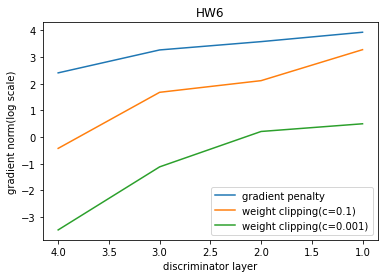

In [60]:
# importing package
import matplotlib.pyplot as plt

# naming the x axis
plt.xlabel('discriminator layer')
# naming the y axis
plt.ylabel('gradient norm(log scale)')
 
# giving a title to my graph
plt.title('HW6')

# create data
x = [1,2,3,4]

# plot lines
plt.plot(x, line1, label = "gradient penalty")
plt.plot(x, line2, label = "weight clipping(c=0.1)")
plt.plot(x, line3, label = "weight clipping(c=0.001)")

plt.gca().invert_xaxis()
plt.legend()
plt.show()
